Importing required libraries

In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten, SimpleRNN, GRU, LSTM, Dropout, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

Extracting the dataset of roses and tulips

In [2]:
# Download the zip file saved in the Drive 
!pip install -U -q PyDrive

#File ID
zip_id = '1sajk-SXeemD-0JXDoTMezv3hlvoHUi4v'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zip file
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('roses_and_tulips.zip')
!unzip -qq -o roses_and_tulips.zip

Making new directories for dividing train and test dataset

In [3]:
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/roses
!mkdir data/train/tulips
!mkdir data/test/roses
!mkdir data/test/tulips

Moving first 200 images to train and remaining 100 images to validation for both roses and tulips

In [4]:
!ls roses_and_tulips/roses/*.jpg | head -200 | xargs -I{} mv {} data/train/roses
!ls roses_and_tulips/roses/*.jpg | head -100 | xargs -I{} mv {} data/test/roses
!ls roses_and_tulips/tulips/*.jpg | head -200 | xargs -I{} mv {} data/train/tulips
!ls roses_and_tulips/tulips/*.jpg | head -100 | xargs -I{} mv {} data/test/tulips

train_path = 'data/train'
valid_path = 'data/test'

Setting image size to 150X150 and checking number of images in train and test

In [5]:
IMAGE_SIZE = [150, 150]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print(len(image_files))
print(len(valid_image_files))

# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

400
200
['data/train/roses', 'data/train/tulips']


Reading training data for roses and tulips and transforming it using PIL

In [6]:
from PIL import Image

def create_dataset_PIL(img_folder):
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
      
            image_path= os.path.join(img_folder, dir1,  file)      #Reading each image from directory
            image= np.array(Image.open(image_path))                #Converting to array
            image= np.resize(image,IMAGE_SIZE)                     #Resizing to 150 X 150
            image = image.astype('float32')                        #Converting to float
            image /= 255                                           #Normalizing
            img_data_array.append(image)                           #Appending to final array
            class_name.append(dir1)                                #Appending final target class
    return img_data_array , class_name

PIL_img_data_train, class_name_train=create_dataset_PIL(train_path)

In [7]:
#Checking target class
target_dict_train={k: v for v, k in enumerate(np.unique(class_name_train))}
target_dict_train

{'roses': 0, 'tulips': 1}

In [8]:
#Creating target class train sample (y_train)
target_val_train=  [target_dict_train[class_name_train[i]] for i in range(len(class_name_train))]
len(target_val_train)

400

Reading validation data for roses and tulips and transforming it using PIL

In [9]:
PIL_img_data_valid, class_name_valid=create_dataset_PIL(valid_path)

In [10]:
#Checking target class for validation dataset
target_dict_valid={k: v for v, k in enumerate(np.unique(class_name_valid))}
target_dict_valid

{'roses': 0, 'tulips': 1}

In [11]:
#Creating target class array for validation  dataset (y_test)
target_val_valid=  [target_dict_valid[class_name_valid[i]] for i in range(len(class_name_valid))]
len(target_val_valid)

200

Making training and validation dataset compatible befor modeling

In [12]:
X_train = np.array(PIL_img_data_train)
y_train = np.array(target_val_train)
X_test = np.array(PIL_img_data_valid)
y_test = np.array(target_val_valid)

**Classification with LSTM**

In [15]:
# Defining the model
model = Sequential()
model.add(Dense(units=6, input_shape=X_train[0].shape,activation='relu'))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))

# Compile and train
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
r = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10)

Epoch 1/10
13/13 [==============================] - 9s 418ms/step - loss: 0.6920 - accuracy: 0.4875 - val_loss: 0.6967 - val_accuracy: 0.5100
Epoch 2/10
13/13 [==============================] - 5s 397ms/step - loss: 0.6877 - accuracy: 0.5700 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - 5s 385ms/step - loss: 0.6879 - accuracy: 0.5450 - val_loss: 0.6937 - val_accuracy: 0.5100
Epoch 4/10
13/13 [==============================] - 5s 391ms/step - loss: 0.6780 - accuracy: 0.6075 - val_loss: 0.7029 - val_accuracy: 0.5150
Epoch 5/10
13/13 [==============================] - 5s 396ms/step - loss: 0.6619 - accuracy: 0.6150 - val_loss: 0.6927 - val_accuracy: 0.5750
Epoch 6/10
13/13 [==============================] - 5s 379ms/step - loss: 0.6574 - accuracy: 0.6150 - val_loss: 0.7245 - val_accuracy: 0.5450
Epoch 7/10
13/13 [==============================] - 5s 400ms/step - loss: 0.6452 - accuracy: 0.6325 - val_loss: 0.6867 - val_accuracy: 0.5400
Epoch 

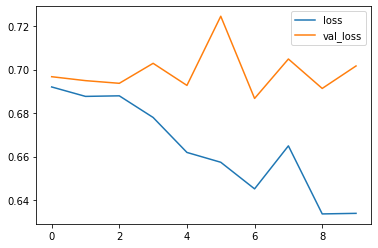

In [16]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

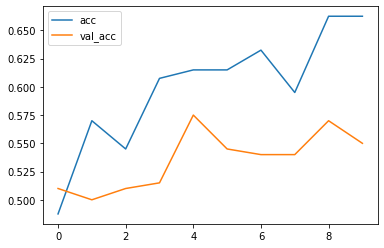

In [17]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

**Classification with GRU**

In [18]:
# Defining the model
model = Sequential()
model.add(Dense(units=6, input_shape=X_train[0].shape,activation='relu'))
model.add(GRU(100,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))

# Compile and train
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
r = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10)

Epoch 1/10
13/13 [==============================] - 9s 507ms/step - loss: 0.6999 - accuracy: 0.5050 - val_loss: 0.6930 - val_accuracy: 0.5200
Epoch 2/10
13/13 [==============================] - 6s 479ms/step - loss: 0.6934 - accuracy: 0.5425 - val_loss: 0.6941 - val_accuracy: 0.5200
Epoch 3/10
13/13 [==============================] - 6s 457ms/step - loss: 0.6875 - accuracy: 0.5675 - val_loss: 0.7025 - val_accuracy: 0.5000
Epoch 4/10
13/13 [==============================] - 6s 471ms/step - loss: 0.6788 - accuracy: 0.5500 - val_loss: 0.7016 - val_accuracy: 0.4850
Epoch 5/10
13/13 [==============================] - 6s 476ms/step - loss: 0.6816 - accuracy: 0.5700 - val_loss: 0.7002 - val_accuracy: 0.4900
Epoch 6/10
13/13 [==============================] - 6s 475ms/step - loss: 0.6778 - accuracy: 0.5600 - val_loss: 0.7705 - val_accuracy: 0.5000
Epoch 7/10
13/13 [==============================] - 6s 469ms/step - loss: 0.6725 - accuracy: 0.5675 - val_loss: 0.6950 - val_accuracy: 0.5400
Epoch 

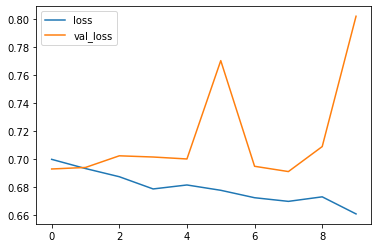

In [19]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

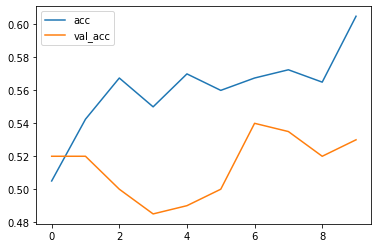

In [20]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

**Classification with SimpleRNN**

In [21]:
# Defining the model
model = Sequential()
model.add(Dense(units=6, input_shape=X_train[0].shape,activation='relu'))
model.add(SimpleRNN(100,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))

# Compile and train
model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])
r = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10)

Epoch 1/10
13/13 [==============================] - 4s 225ms/step - loss: 0.6936 - accuracy: 0.4725 - val_loss: 0.6926 - val_accuracy: 0.4950
Epoch 2/10
13/13 [==============================] - 3s 205ms/step - loss: 0.6936 - accuracy: 0.4925 - val_loss: 0.6926 - val_accuracy: 0.4900
Epoch 3/10
13/13 [==============================] - 3s 199ms/step - loss: 0.6941 - accuracy: 0.4675 - val_loss: 0.6926 - val_accuracy: 0.4800
Epoch 4/10
13/13 [==============================] - 3s 201ms/step - loss: 0.6934 - accuracy: 0.4800 - val_loss: 0.6926 - val_accuracy: 0.4850
Epoch 5/10
13/13 [==============================] - 3s 204ms/step - loss: 0.6937 - accuracy: 0.4800 - val_loss: 0.6927 - val_accuracy: 0.4750
Epoch 6/10
13/13 [==============================] - 3s 201ms/step - loss: 0.6938 - accuracy: 0.4925 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 7/10
13/13 [==============================] - 3s 204ms/step - loss: 0.6937 - accuracy: 0.4875 - val_loss: 0.6927 - val_accuracy: 0.4900
Epoch 

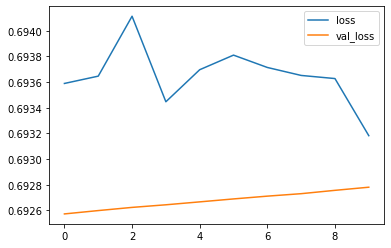

In [22]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

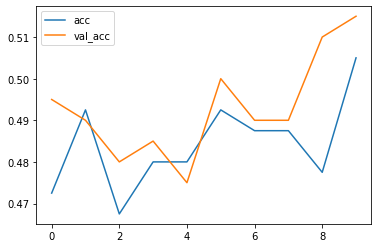

In [23]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

**Results**

**Transfer Learning:** Model trained with weights from Inceptionv3 with data augmentation gives training accuracy as 92% (0.28 loss) and validation accuracy as 86% (0.43 loss). Along with data augmentation it is compute expensive but generalize well on vlaidation dataset.

**LSTM, GRU & SimpleRNN:** These models gives highest validation accuracy between 50%-55% and training accuracy around 60%. The validation loss doesn't reduce further than 0.69.

Hence models with transfer learning perform well as compared to RNN models.